In [2]:
from schema import df_sales,spark
from pyspark.sql.functions import when,col,udf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pyspark.sql.types import StringType,FloatType
import seaborn as sns
import numpy as np

/home/camille/.local/lib/python3.6/site-packages/pyspark/context.py:238: FutureWarning: Python 3.6 support is deprecated in Spark 3.2.
  FutureWarning


In [3]:
def mult(quantity, price):
    return round(quantity*float(price.replace(',', '.')), 2)

multiply = udf(mult,FloatType())

def date_to_day(s):
    return datetime.strptime(s,"%d/%m/%Y").strftime('%A')

reg_sal = udf(lambda q : date_to_day(q), StringType())  

In [4]:
client_ca_jour = df_sales.select(["Date","Time","TicketNumber","Quantity","UnitPrice"])\
                .withColumn("Day",reg_sal(col("Date")))




In [5]:
ca_jour = client_ca_jour.withColumn("Subtotal",multiply("Quantity","UnitPrice")).groupBy("Day").sum("Subtotal").withColumnRenamed("sum(Subtotal)", "CA")
ca_jour_pd = ca_jour.toPandas()

In [6]:
client_jour = client_ca_jour.dropDuplicates(["TicketNumber"]).groupBy("Day").count().withColumnRenamed("count","nb_clients")

client_jour_pd = client_jour.toPandas()

In [7]:
nb_jour = client_ca_jour.dropDuplicates(["Date"]).groupBy("Day").count().withColumnRenamed("count()","number_days")

nb_jour_pd = nb_jour.toPandas()



### Graphique nombre totale de clients et de CA par jour sur une semaine 

In [8]:
DAYS = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']


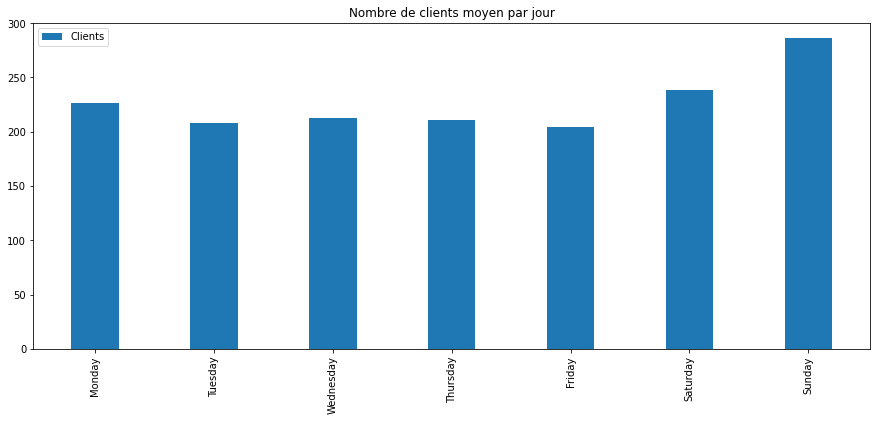

In [9]:
plt.figure(figsize = (15,6))
plt.bar(DAYS, [client_jour_pd.loc[client_jour_pd.Day==day].nb_clients.values[0]/nb_jour_pd.loc[nb_jour_pd.Day == day].values[0][1] for day in DAYS],0.4,label = "Clients")
plt.xticks(rotation=90)
plt.legend()
plt.title("Nombre de clients moyen par jour")
plt.show()

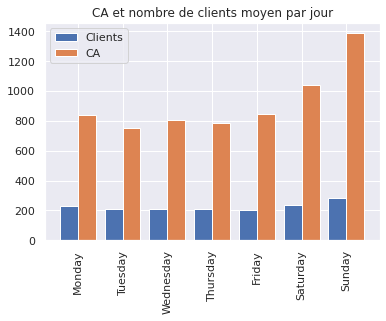

In [67]:
X_axis = np.arange(7)
plt.bar(X_axis -0.2, [client_jour_pd.loc[client_jour_pd.Day==day].nb_clients.values[0]/nb_jour_pd.loc[nb_jour_pd.Day == day].values[0][1] for day in DAYS],0.4,label = "Clients")
plt.bar(X_axis +0.2, [ca_jour_pd.loc[ca_jour_pd.Day==day].CA.values[0]/nb_jour_pd.loc[nb_jour_pd.Day == day].values[0][1] for day in DAYS],0.4,label = "CA")
plt.xticks(X_axis,DAYS)
plt.xticks(rotation=90)
plt.legend()
plt.title("CA et nombre de clients moyen par jour")
plt.show()